In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sentiment_analysis_vader import *
from sentiment_analysis_textblob import *
from sentiment_analysis_openai import *
from sentiment_analysis_bert import *
import os
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from nlp.comments_preprocessing import *
print(os.getcwd())


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
c:\Users\Niklas Kothe\Documents\Python4Business\nlp\sentiment_analysis


In [2]:
# Load the CSV file from the constructed file path
data,comments = read_dataframes()

**Sentiment Analysis with VADER**

In [3]:
# Copy the original comments DataFrame to avoid modifying the original data
comments_vader = comments.copy()

# Add sentiment scores to the copied DataFrame for both original and cleaned comments
comments_vader = vader_add_sentiment_scores(comments_vader, 'Comment', 'cleaned_Comment')

# Apply the final_sentiment function to the 'compound' column to categorize sentiment
comments_vader["sentiment"] = comments_vader["compound"].apply(lambda x: vader_final_sentiment(x))

# Apply the final_sentiment function to the 'compound_cleaned' column to categorize cleaned sentiment
comments_vader["sentiment_cleaned"] = comments_vader["compound_cleaned"].apply(lambda x: vader_final_sentiment(x))

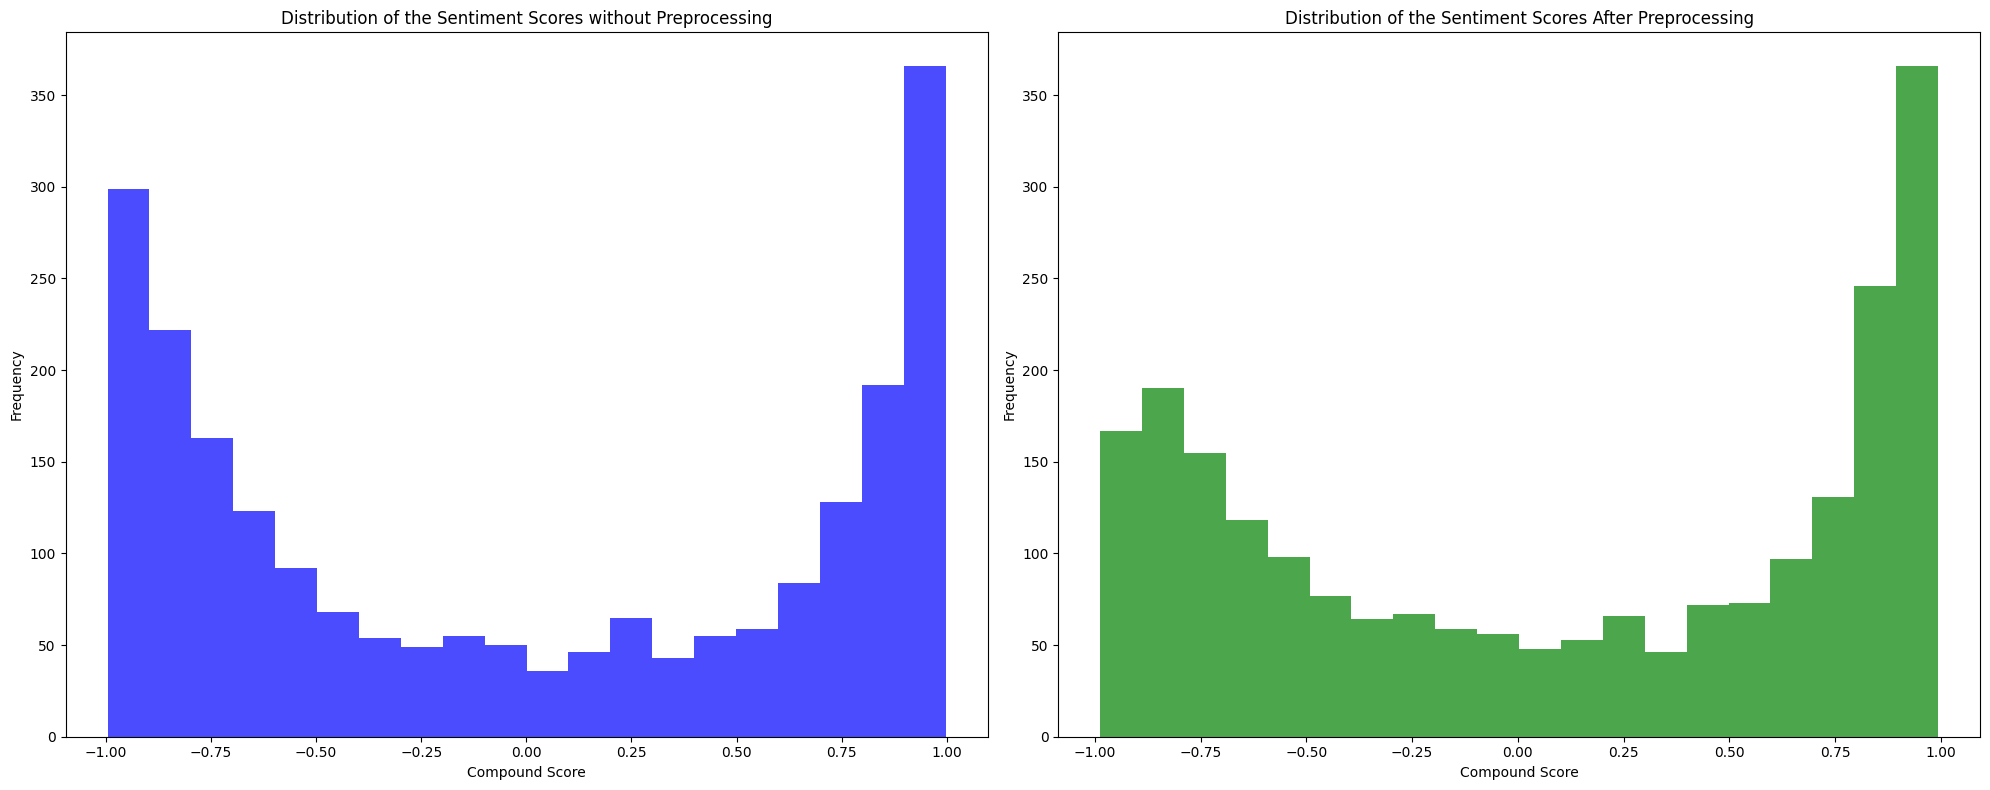

In [4]:
vader_plot_sentiment_distributions(comments_vader)

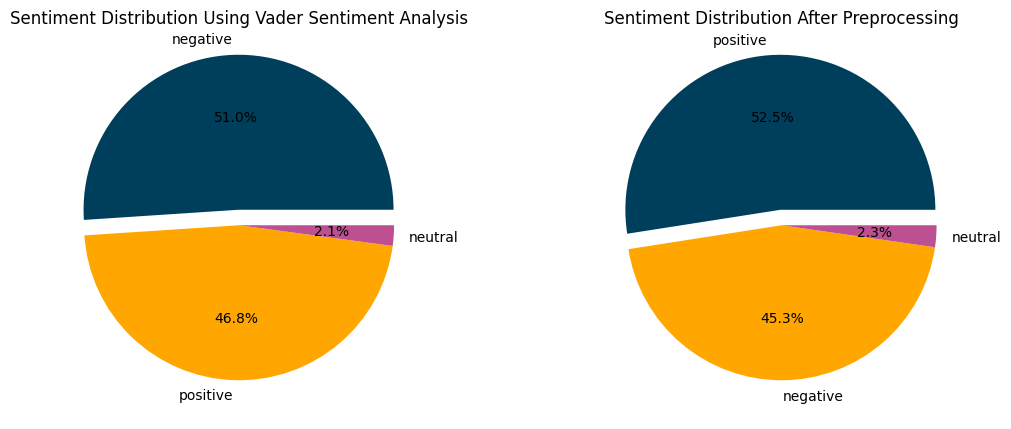

In [5]:
# Plot the sentiment proportions for both original and cleaned sentiment labels
vader_plot_sentiment_proportions(comments_vader, "sentiment", "sentiment_cleaned")

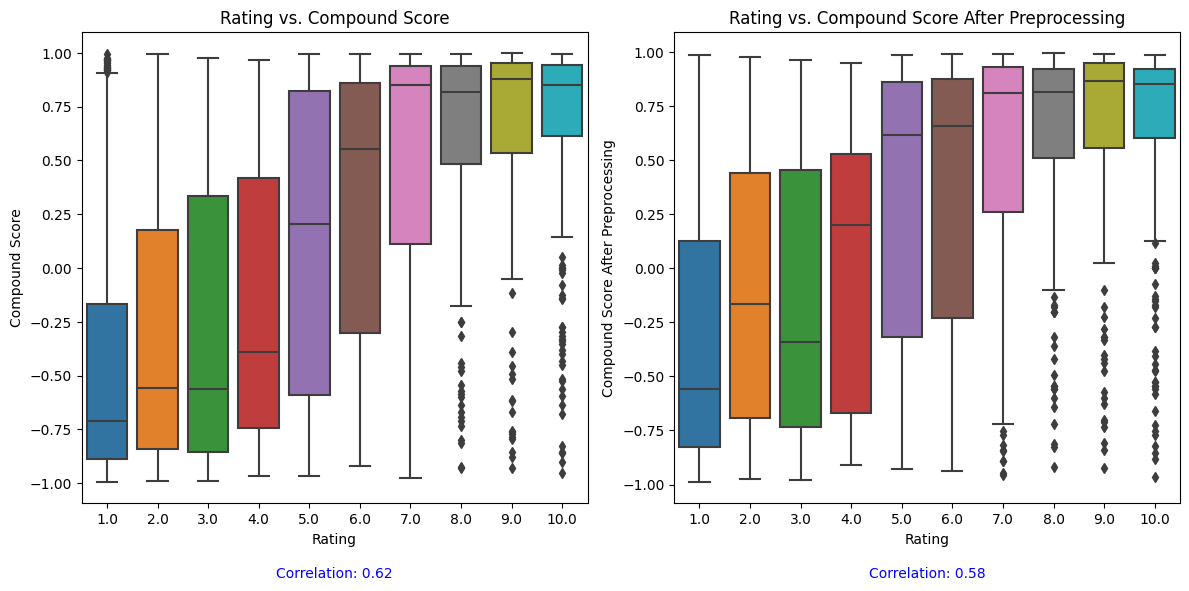

In [6]:
vader_plot_rating_vs_compound(data, comments_vader)

**Sentiment Analysis with Textblob**

In [7]:
# Copy the original comments DataFrame to avoid modifying the original data
comments_textblob = comments.copy()

In [8]:
comments_textblob['polarity'], comments_textblob['subjectivity'] = zip(*comments_textblob['Comment'].apply(textblob_sentiment))

comments_textblob['cleaned_polarity'], comments_textblob['cleaned_subjectivity'] = zip(
    *comments_textblob['cleaned_Comment'].apply(textblob_sentiment))

comments_textblob["polarity_group"] = comments_textblob["polarity"].apply(lambda compound: textblob_final_sentiment(compound))

comments_textblob["polarity_group_cleaned"] = comments_textblob["cleaned_polarity"].apply(lambda compound: textblob_final_sentiment(compound))

comments_textblob["subjectivity_group"] = comments_textblob["subjectivity"].apply(lambda compound: textblob_final_subjectivity(compound))

comments_textblob["subjectivity_group_cleaned"] = comments_textblob["cleaned_subjectivity"].apply(
    lambda compound: textblob_final_subjectivity(compound))

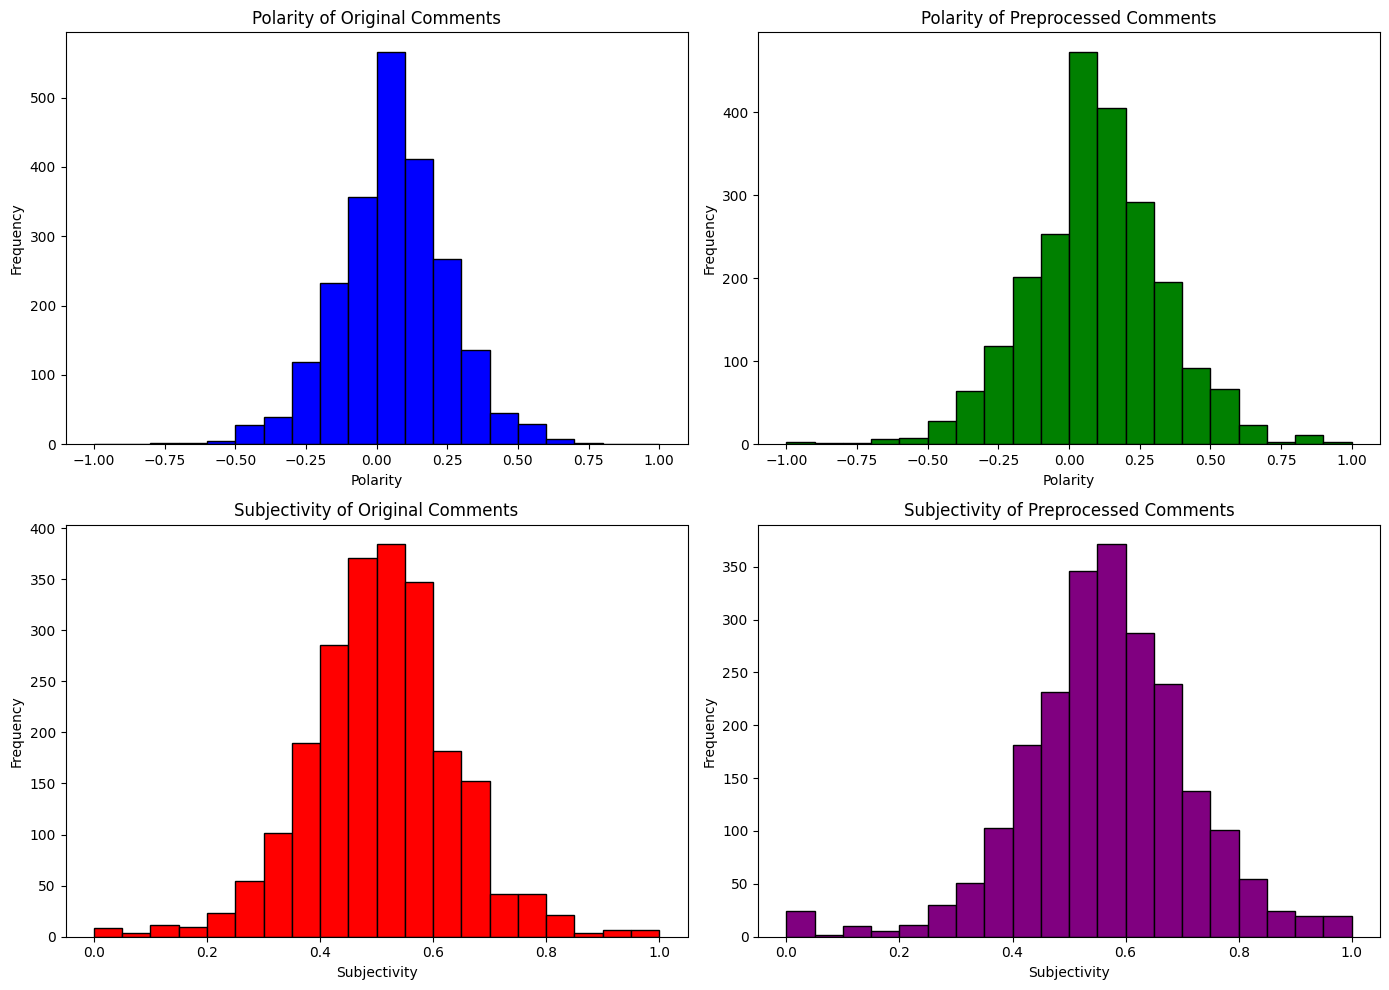

In [9]:
# Plot the distribution of sentiment scores using TextBlob analysis
textblob_plot_score_distribution(comments_textblob)

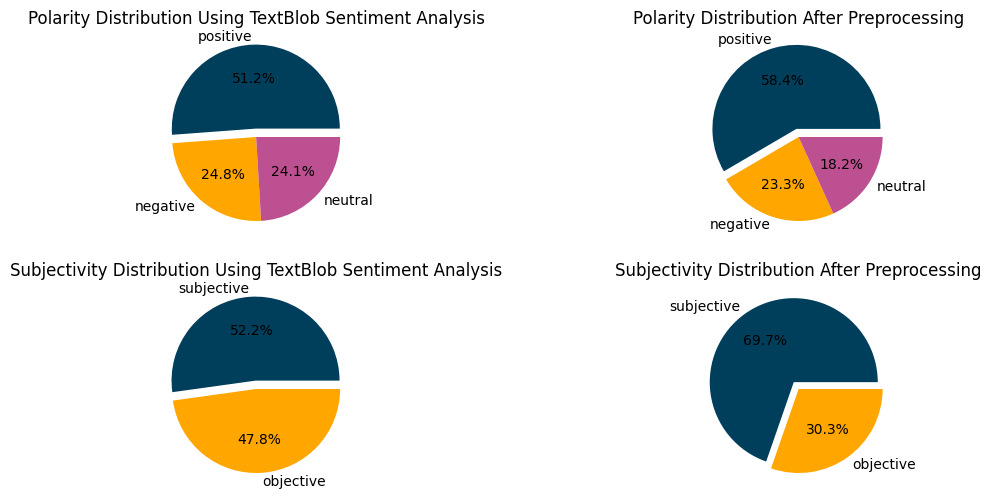

In [10]:
textblob_plot_pie_distribution(comments_textblob)


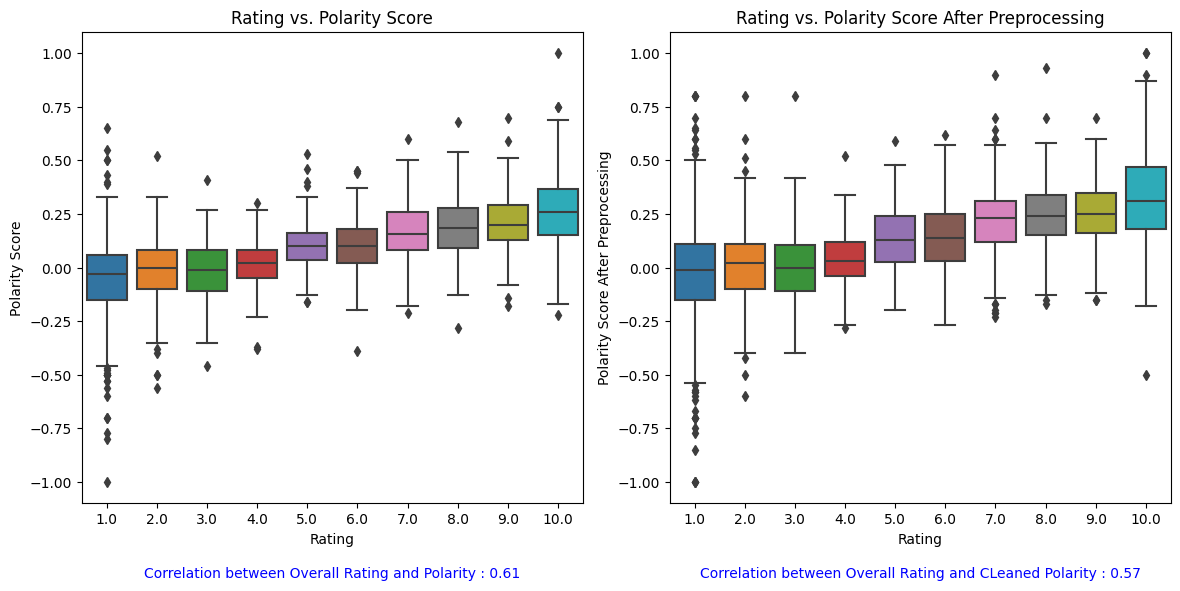

In [11]:
textblob_analyze_ratings_vs_sentiment(data, comments_textblob)

**Sentiment Analysis with OpenAI**

In [13]:
comments_openai = read_openai_sentiment_data()

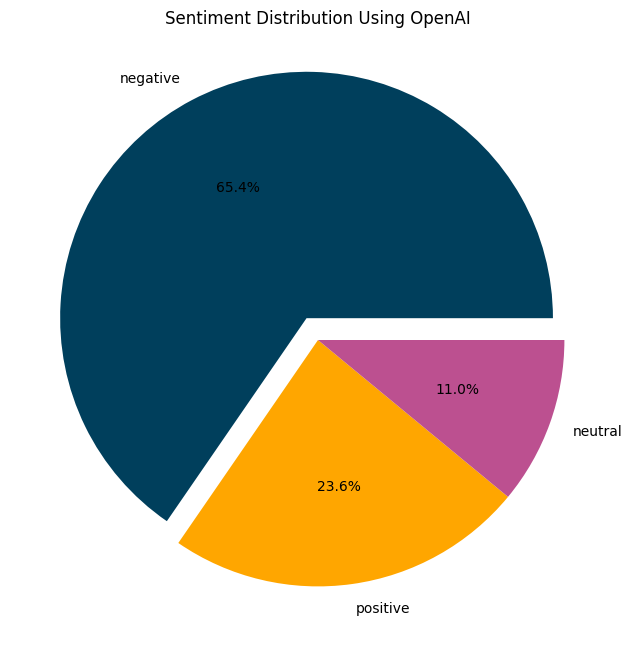

In [14]:
openai_plot_sentiment_proportions(comments_openai, "openai_sentiment")

**Sentiment Analysis with Bert**

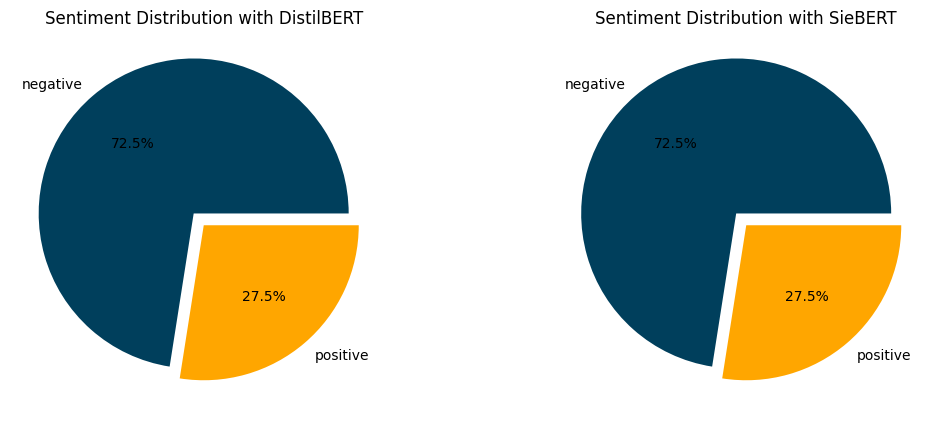

In [12]:
comments_bert = read_bert_sentiment_data()
bert_plot_sentiment_proportions(comments_bert, "sentiment_comment_distilbert", "sentiment_comment_siebert")

**Benchmark Analysis**

In [21]:
# Map the sentiment values to numerical values
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
comments_vader["vader_sentiment"] = comments_vader["sentiment"].map(sentiment_mapping)
comments_vader["vader_sentiment_preprocessed"] = comments_vader["sentiment_cleaned"].map(sentiment_mapping)

# Create a new DataFrame with the required columns
vader_sentiments_df = comments_vader[["Comment", "vader_sentiment", "vader_sentiment_preprocessed"]]

In [23]:
comments_textblob["textblob_sentiment"] = comments_textblob["polarity_group"].map(sentiment_mapping)
comments_textblob["textblob_sentiment_preprocessed"] = comments_textblob["polarity_group_cleaned"].map(sentiment_mapping)
textblob_sentiments_df = comments_textblob[["Comment", "textblob_sentiment", "textblob_sentiment_preprocessed"]]

In [27]:
openai_sentiments_df = comments_openai[["Comment", "openai_sentiment"]]

In [28]:
sentiment_mapping_bert = {"POSITIVE": 1, "NEGATIVE": -1, "NEUTRAL": 0}
comments_bert["distilBERT_sentiment"] = comments_bert["sentiment_comment_distilbert"].map(sentiment_mapping_bert)
comments_bert["sieBERT_sentiment"] = comments_bert["sentiment_comment_siebert"].map(sentiment_mapping_bert)
bert_sentiments_df = comments_bert[["Comment", "distilBERT_sentiment", "sieBERT_sentiment"]]

In [33]:
merged_sentiments_df = pd.merge(vader_sentiments_df, textblob_sentiments_df, on="Comment", how="outer")
merged_sentiments_df = pd.merge(merged_sentiments_df, openai_sentiments_df, on="Comment", how="outer")
merged_sentiments_df = pd.merge(merged_sentiments_df, bert_sentiments_df, on="Comment", how="outer")


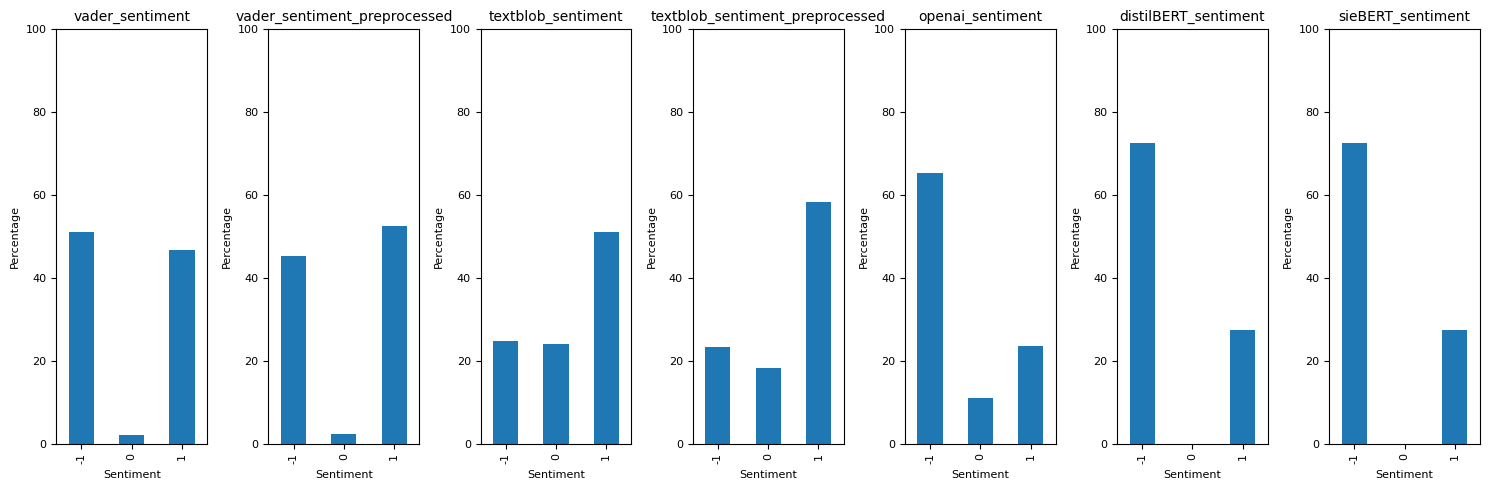

In [36]:
# Exclude the 'Comment' column
columns = merged_sentiments_df.columns.drop('Comment')

# Calculate the percentage of +1, 0, and -1 values for each column
percentages = merged_sentiments_df[columns].apply(lambda x: x.value_counts(normalize=True) * 100).fillna(0)

# Plotting the bar charts
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(15, 5))

for i, column in enumerate(columns):
    ax = axes[i]
    percentages[column].plot(kind='bar', ax=ax)
    ax.set_title(column, fontsize=10)  # Adjusting the font size of the title
    ax.set_xlabel('Sentiment', fontsize=8)
    ax.set_ylabel('Percentage', fontsize=8)
    ax.set_ylim([0, 100])
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

In [37]:
path = "../../data/test_data_to_be_labeled.csv"
a = pd.read_csv(path)

In [41]:
path = "../../data/labeled_data_for_benchmark_analysis.csv"
labeled_data = pd.read_csv(path)

In [48]:
analysis_df = pd.merge(labeled_data, merged_sentiments_df, on = "Comment", how = "inner")

In [59]:
# Define the sentiment columns
sentiment_columns = [
    "vader_sentiment", "vader_sentiment_preprocessed", "textblob_sentiment",
    "textblob_sentiment_preprocessed", "openai_sentiment", "distilBERT_sentiment",
    "sieBERT_sentiment"
]

# Initialize dictionaries to store the metrics
metrics_results = {
    'accuracy': {},
    'precision': {},
    'recall': {},
    'f1_score': {}
}

In [61]:
# Calculate metrics for each sentiment column
for column in sentiment_columns:
    y_true = analysis_df["annotations"]
    y_pred = analysis_df[column]
    
    metrics_results['accuracy'][column] = accuracy_score(y_true, y_pred)
    metrics_results['precision'][column] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics_results['recall'][column] = recall_score(y_true, y_pred, average='macro')
    metrics_results['f1_score'][column] = f1_score(y_true, y_pred, average='macro')

# Convert metrics results to a DataFrame
metrics_df = pd.DataFrame(metrics_results)

In [65]:
metrics_df
import os
print(os.getcwd())


c:\Users\Niklas Kothe\Documents\Python4Business\nlp\sentiment_analysis


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (7).

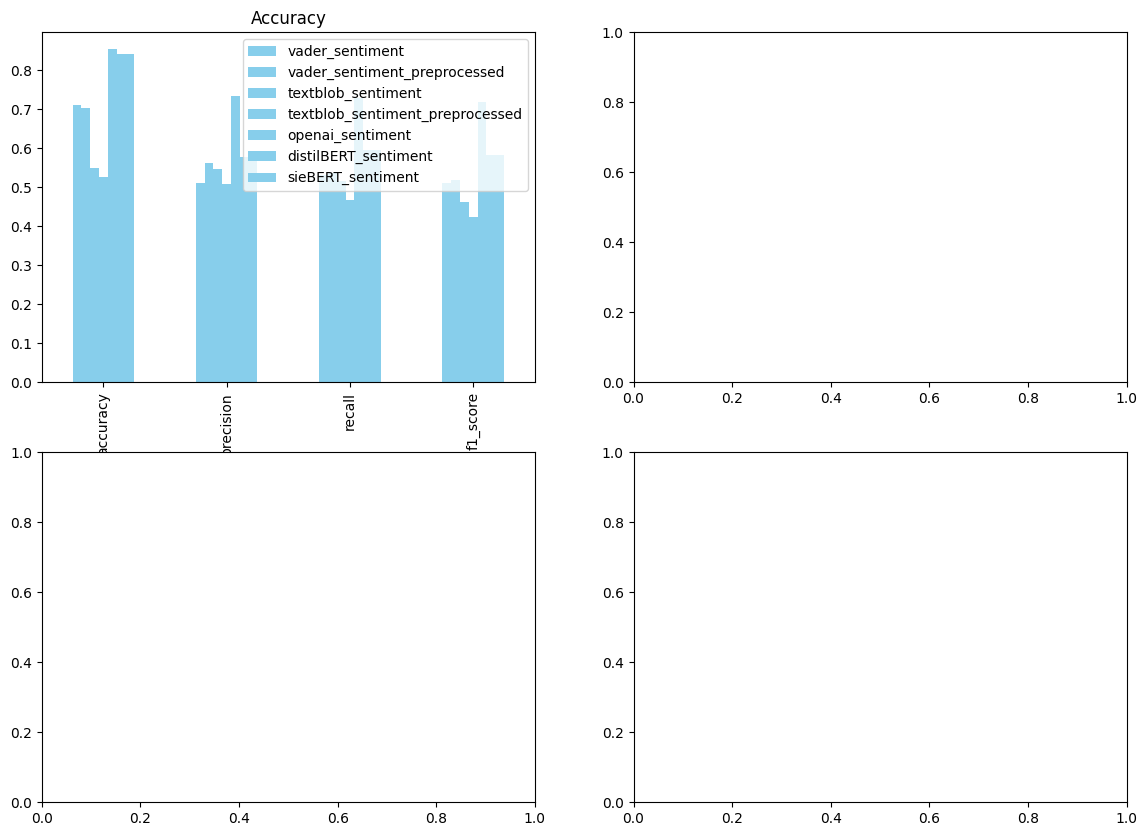

In [62]:
# Convert the accuracy results to a pandas Series and sort by values in descending order
accuracy_series = pd.Series(accuracy_results).sort_values(ascending=False)


# Plot the results
plt.figure(figsize=(10, 6))
ax = accuracy_series.plot(kind='bar', color='skyblue')
plt.title('Accuracy of Different Sentiment Analysis Methods')
plt.xlabel('Sentiment Analysis Method')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)  # Adding a grid

# Add the accuracy scores above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()